## AutoEncoder for FASHION MNIST : PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Step 0. Device Stepup

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cpu


Hyperparameters

In [3]:
learning_rate = 1e-3
batch_size = 100
epochs = 20

### Step 1. Data -  target class : 10

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=10000)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. AE Model

In [9]:
# Step 2. Model
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.SELU(),
            nn.Linear(100, 30),
            nn.SELU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.SELU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x).view(-1, 1, 28, 28)

        return out

model = AE().to(device)

### Step 3. Loss,Optimizer, Metric

In [10]:
# Step 3. Loss and Optimizer 
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. Train the model

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    print(f"Train - Avg loss: {train_loss:>8f}", end = "  ")

    return train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f"Test - Avg loss: {test_loss:>8f}")

    return test_loss

In [12]:
train_loss = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)

    loss_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)

print("Done!")

Epoch 1 :  Train - Avg loss: 0.030617  Test - Avg loss: 0.019818
Epoch 2 :  Train - Avg loss: 0.017937  Test - Avg loss: 0.016405
Epoch 3 :  Train - Avg loss: 0.015511  Test - Avg loss: 0.014841
Epoch 4 :  Train - Avg loss: 0.014264  Test - Avg loss: 0.013885
Epoch 5 :  Train - Avg loss: 0.013488  Test - Avg loss: 0.013285
Epoch 6 :  Train - Avg loss: 0.012987  Test - Avg loss: 0.012889
Epoch 7 :  Train - Avg loss: 0.012636  Test - Avg loss: 0.012609
Epoch 8 :  Train - Avg loss: 0.012375  Test - Avg loss: 0.012380
Epoch 9 :  Train - Avg loss: 0.012166  Test - Avg loss: 0.012188
Epoch 10 :  Train - Avg loss: 0.011989  Test - Avg loss: 0.012018
Epoch 11 :  Train - Avg loss: 0.011823  Test - Avg loss: 0.011858
Epoch 12 :  Train - Avg loss: 0.011647  Test - Avg loss: 0.011694
Epoch 13 :  Train - Avg loss: 0.011476  Test - Avg loss: 0.011533
Epoch 14 :  Train - Avg loss: 0.011331  Test - Avg loss: 0.011402
Epoch 15 :  Train - Avg loss: 0.011209  Test - Avg loss: 0.011281
Epoch 16 :  Train -

### Plot the Training/Test loss

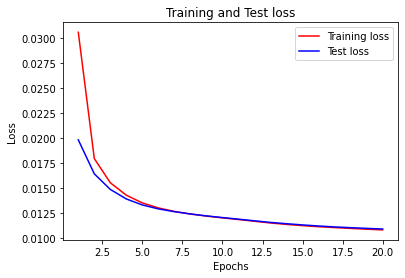

In [13]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot images

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


### Show Reconstruction Images

In [7]:
def show_reconstructions(model, dataloader=test_dataloader, n_images=5):
    with torch.no_grad():
      images, y = next(iter(dataloader))
      reconstructions = model(images[:n_images].to(device)).cpu()

    print(images.shape, reconstructions.shape)
    images = images.squeeze()
    reconstructions = reconstructions.squeeze()
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


### Save Imges

In [8]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Show Original and Reconstruected Images

torch.Size([10000, 1, 28, 28]) torch.Size([5, 1, 28, 28])
Saving figure reconstruction_plot


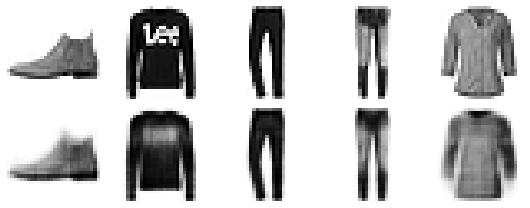

In [14]:
show_reconstructions(model, test_dataloader, 5)
save_fig("reconstruction_plot")

In [15]:
### Step 5. Test the Model

In [25]:
with torch.no_grad():
  x_test, y_test = next(iter(test_dataloader))
  X_test = x_test.to(device)
  X_test_compressed = model.encoder(X_test).cpu().numpy()

X_test = X_test.squeeze().cpu().numpy()
y_test = y_test.cpu().numpy()
print(X_test.shape, y_test.shape, X_test_compressed.shape)

(10000, 28, 28) (10000,) (10000, 30)


### Image Visualization with TSNE

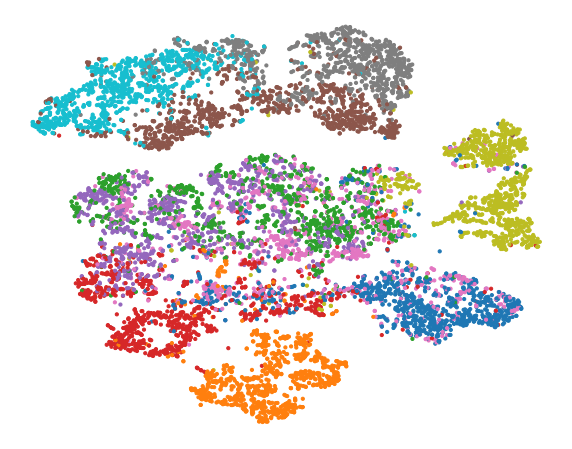

In [26]:
tsne = TSNE()
X_test_2D = tsne.fit_transform(X_test_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

plt.figure(figsize=(10, 8))
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### Plot Fashion MNIST on 2D Domain

Saving figure fashion_mnist_visualization_plot


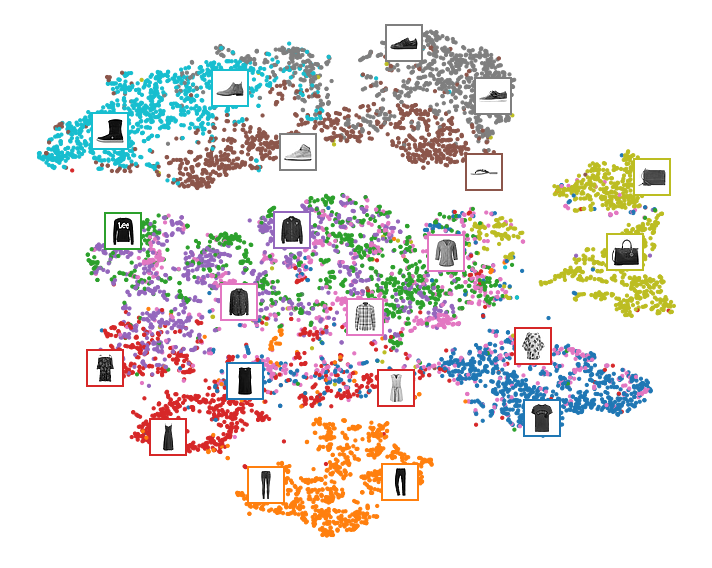

In [27]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()